The purpose of this project is to perform topic modeling on data scraped from glassdoor.com

For more info on how the data was collected, please see [https://github.com/djkjohnston/glassdoor_scrape](https://github.com/djkjohnston/glassdoor_scrape)

In [1]:
import pandas as pd
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
interviews = pd.read_csv('data/zillow_interviews.csv')

In [3]:
interviews.head()

,application_proccess,company,interview_description,interview_difficulty,interview_experience,interview_questions,job_title,offer_status,review_date
0,I applied online. The process took 2 weeks. I ...,Zillow,Discussions with the recruiter were positive a...,Easy Interview,Negative Experience,NaN,Senior Software Engineer,No Offer,"Jan 9, 2018"
1,I applied online. The process took 2 weeks. I ...,Zillow,2 Phone calls. 1 call with a recruiter. 1 call...,Average Interview,Positive Experience,"Tell me about your experience ,Answer Question",Account Executive,Accepted Offer,"Jan 18, 2018"
2,I applied online. The process took 4+ weeks. I...,Zillow,"I applied online. Within a couple days, a recr...",Average Interview,Positive Experience,Why are you looking to leave your current job...,Data Analyst,Accepted Offer,"Jan 16, 2018"
3,The process took 4 weeks. I interviewed at Zil...,Zillow,"Very efficient, friendly process that started ...",Average Interview,Positive Experience,"Why Zillow? ,Answer Question, What motivate...",Business Consultant,Accepted Offer,"Jan 5, 2018"
4,I applied through an employee referral. I inte...,Zillow,Was contacted by a recruiter who then set up a...,Easy Interview,Neutral Experience,"- Tell me about yourself,- Tell me about a ma...",Marketing Strategy,Declined Offer,"Jan 8, 2018"


In [4]:
interviews['interview_description'][0]

"Discussions with the recruiter were positive and courteous. I felt like Zillow understood my background and wanted to work with me. The moment I spoke with an engineer, though, I felt differently. All he wanted to do was talk about himself. He barely asked me a thing about my experience or what I was interested in. I am a very senior person who was asked a low-ball question. I provided a good, efficient answer and tested it well, but still got rejected. Pretty short-sighted. I've worked with too many snowflakes in my career and I don't want to work with another."

In [5]:
interviews['interview_questions'][0]

nan

In [6]:
interviews['interview_questions'][4]

' - Tell me about yourself,- Tell me about a marketing project you have done,- Why Zillow? \xa0 ,Answer Question'

In [7]:
interviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 9 columns):
application_proccess     514 non-null object
company                  535 non-null object
interview_description    535 non-null object
interview_difficulty     487 non-null object
interview_experience     517 non-null object
interview_questions      504 non-null object
job_title                535 non-null object
offer_status             535 non-null object
review_date              535 non-null object
dtypes: object(9)
memory usage: 37.7+ KB


In [8]:
interviews.describe().T

,count,unique,top,freq
application_proccess,514,440,I applied online. I interviewed at Zillow.,14
company,535,1,Zillow,535
interview_description,535,535,Included 2 phone interviews and 1 in person in...,1
interview_difficulty,487,3,Average Interview,341
interview_experience,517,6,Positive Experience,293
interview_questions,504,489,"Why Zillow? ,Answer Question",12
job_title,535,203,Software Development Engineer,65
offer_status,535,3,No Offer,326
review_date,535,454,"Aug 10, 2015",4


## Data cleaning and prep

Tasks:


* `application process`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
    * consider how to deal with '2 weeks' vs 'two weeks'
* `interview_description`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
* `interview_difficulty`
    * leave as is for now. Maybe map responses to values
* `interview_experience`
    * leave as is for now. Maybe map responses to values
* `interview_questions`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
    * Clean out 'Answer Question' and '1 Answer' kinds of text
* `job_title`
    * clean punctiation and symbols
* `offer_status`
    * leave as is for now. Maybe map responses to values
* `review_date`
    * convert to datetime field
   

In [9]:
interviews['review_date'] = pd.to_datetime(interviews['review_date'])
interviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 9 columns):
application_proccess     514 non-null object
company                  535 non-null object
interview_description    535 non-null object
interview_difficulty     487 non-null object
interview_experience     517 non-null object
interview_questions      504 non-null object
job_title                535 non-null object
offer_status             535 non-null object
review_date              535 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 37.7+ KB


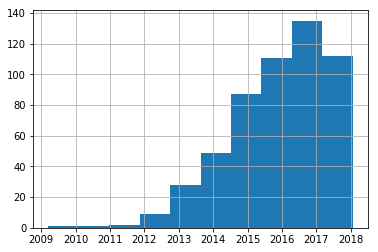

In [10]:
interviews['review_date'].hist()

Time to clean `job_title`, `application_process`, `interview_description`, and `interview_questions`

In [11]:
def cleaner(text):
    #simple text cleaning
    table = str.maketrans({punc:None for punc in string.punctuation})

        
    mapping = [('&#39;', ''), 
               ('<br />', ''), 
               ('<.*>.*</.*>', ''), 
               ('\\ufeff', ''), 
               ('[\d]', ''),  
               ('\[.*\]', ''),  
#                ('[^a-z ]', ''),
               ('question', ''),
               ('answer', ''), 
              ]
    if type(text) == str:
        for k, v in mapping:
            text = re.sub(k, v, text)
            text = text.translate(table)    
           
        #remove stop words
        text = " ".join([word for word in text.lower().split() if word not in eng_stop])

        # lemmatization 
        text = " ".join(lemma.lemmatize(word) for word in text.split())


    return text

In [12]:
eng_stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

interviews['interview_questions'] = interviews['interview_questions'].str.lower().apply(cleaner)
interviews['application_proccess'] = interviews['application_proccess'].str.lower().apply(cleaner)
interviews['interview_description'] = interviews['interview_description'].str.lower().apply(cleaner)
interviews['job_title'] = interviews['job_title'].str.lower().apply(cleaner)

In [13]:
interviews.head()

,application_proccess,company,interview_description,interview_difficulty,interview_experience,interview_questions,job_title,offer_status,review_date
0,applied online process took week interviewed z...,Zillow,discussion recruiter positive courteous felt l...,Easy Interview,Negative Experience,NaN,senior software engineer,No Offer,2018-01-09
1,applied online process took week interviewed z...,Zillow,phone call call recruiter call sale manager pe...,Average Interview,Positive Experience,tell experience,account executive,Accepted Offer,2018-01-18
2,applied online process took week interviewed z...,Zillow,applied online within couple day recruiter rea...,Average Interview,Positive Experience,looking leave current job tell time profession...,data analyst,Accepted Offer,2018-01-16
3,process took week interviewed zillow denver co,Zillow,efficient friendly process started phone scree...,Average Interview,Positive Experience,zillow motivates sale tactic,business consultant,Accepted Offer,2018-01-05
4,applied employee referral interviewed zillow,Zillow,contacted recruiter set interview one marketin...,Easy Interview,Neutral Experience,tell tell marketing project done zillow,marketing strategy,Declined Offer,2018-01-08


The data is (roughly) cleaned up. Time to set up the topic modeling pipeline. I am starting with Non-negative Matrix Factorization (NMF), since it appears that the topics may be more reliable for relatively small numbers of documents. 

Consider revisiting to impliment Latent Dirichlet Allocation (LDA).

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
    
documents = interviews['interview_questions'][interviews['interview_questions'].notnull()]

In [15]:
#starting with tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=500, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [16]:
len(tfidf_feature_names)

123

In [17]:
#nmf
nmf = NMF(n_components=5, random_state=1, alpha=0.1, l1_ratio=0.5, init='nndsvda')
nmf.fit(tfidf)

NMF(alpha=0.1, beta=1, eta=0.1, init='nndsvda', l1_ratio=0.5, max_iter=200,
  n_components=5, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [18]:
len(nmf.components_)

5

In [19]:
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic {}:".format(topic_idx))
    print(["{}*{:1.4f}".format(tfidf_feature_names[i], topic[i])
                    for i in np.flip(topic.argsort(), axis=0)[:10]])
        

Topic 0:
['zillow*3.1450', 'want*0.1268', 'role*0.1192', 'make*0.1148', 'know*0.1085', 'asked*0.0878', 'whats*0.0650', 'current*0.0466', 'thought*0.0402', 'interested*0.0363']
Topic 1:
['work*2.1206', 'want*1.4131', 'repetitive*0.2904', 'day*0.2196', 'time*0.1921', 'team*0.1505', 'deal*0.1166', 'like*0.0958', 'job*0.0916', 'think*0.0836']
Topic 2:
['sale*2.4119', 'mock*0.2332', 'year*0.1398', 'making*0.1226', 'sell*0.1195', 'asked*0.1135', 'product*0.0972', 'role*0.0902', 'company*0.0875', 'feel*0.0866']
Topic 3:
['tree*1.6941', 'string*0.8700', 'trinary*0.5578', 'binary*0.4622', 'implement*0.4378', 'node*0.3952', 'insert*0.3678', 'delete*0.3462', 'given*0.3233', 'long*0.2810']
Topic 4:
['tell*1.8949', 'experience*1.1459', 'time*1.0882', 'job*0.3131', 'asked*0.2777', 'handle*0.2241', 'interested*0.1560', 'resume*0.1510', 'previous*0.1292', 'management*0.1253']


## Closing the loop

No let's bring the topics into the cleaned `interviews` dataframe.

To do this:
1. Use `nmf.transform` on the tfidf matrix. This should return an array of topic probabilities for each row.
1. Make a `strongest_topic` feature, assigned each record to a particular topic
1. Merge probabilities into `interviews`


In [28]:
topic_probs = pd.DataFrame(nmf.transform(tfidf), columns=['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4'])

In [31]:
topic_probs['Strongest_Topic'] = topic_probs.idxmax(axis=1)

In [34]:
interviews_categorized =  pd.concat([interviews, topic_probs], axis=1)

In [35]:
interviews_categorized.head()

,application_proccess,company,interview_description,interview_difficulty,interview_experience,interview_questions,job_title,offer_status,review_date,Topic0,Topic1,Topic2,Topic3,Topic4,Strongest_Topic
0,applied online process took week interviewed z...,Zillow,discussion recruiter positive courteous felt l...,Easy Interview,Negative Experience,NaN,senior software engineer,No Offer,2018-01-09,0.000000,0.0,0.000000,0.000000,0.317909,Topic4
1,applied online process took week interviewed z...,Zillow,phone call call recruiter call sale manager pe...,Average Interview,Positive Experience,tell experience,account executive,Accepted Offer,2018-01-18,0.000000,0.0,0.000000,0.000000,0.199320,Topic4
2,applied online process took week interviewed z...,Zillow,applied online within couple day recruiter rea...,Average Interview,Positive Experience,looking leave current job tell time profession...,data analyst,Accepted Offer,2018-01-16,0.190872,0.0,0.299311,0.000000,0.000000,Topic2
3,process took week interviewed zillow denver co,Zillow,efficient friendly process started phone scree...,Average Interview,Positive Experience,zillow motivates sale tactic,business consultant,Accepted Offer,2018-01-05,0.092265,0.0,0.000000,0.000000,0.219440,Topic4
4,applied employee referral interviewed zillow,Zillow,contacted recruiter set interview one marketin...,Easy Interview,Neutral Experience,tell tell marketing project done zillow,marketing strategy,Declined Offer,2018-01-08,0.000000,0.0,0.007464,0.007855,0.000664,Topic3


## Time for some charts

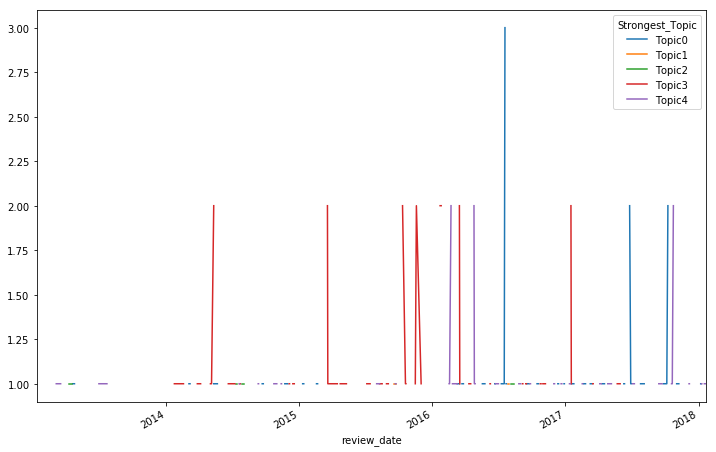

In [59]:
interviews_categorized.groupby(['review_date','Strongest_Topic']).count()['company'].unstack().plot(figsize=(12,8))

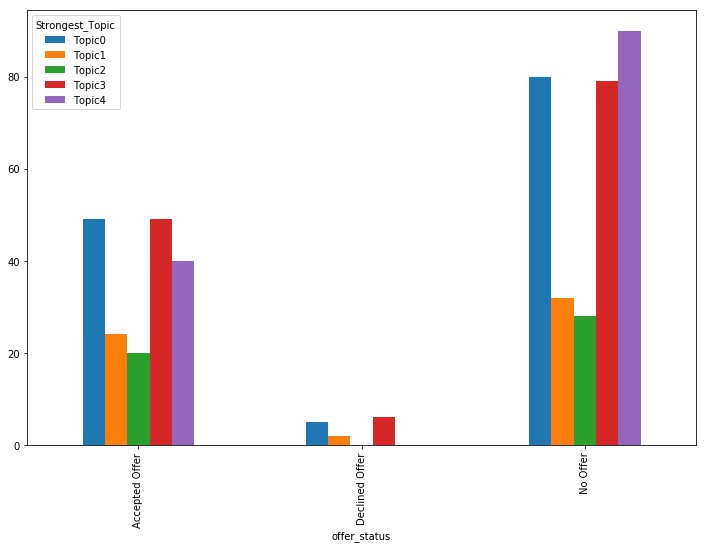

In [64]:
interviews_categorized.groupby(['offer_status','Strongest_Topic']). \
    count()['company'].unstack().plot.bar(figsize=(12,8))

In [65]:
interviews_categorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 15 columns):
application_proccess     514 non-null object
company                  535 non-null object
interview_description    535 non-null object
interview_difficulty     487 non-null object
interview_experience     517 non-null object
interview_questions      504 non-null object
job_title                535 non-null object
offer_status             535 non-null object
review_date              535 non-null datetime64[ns]
Topic0                   504 non-null float64
Topic1                   504 non-null float64
Topic2                   504 non-null float64
Topic3                   504 non-null float64
Topic4                   504 non-null float64
Strongest_Topic          504 non-null object
dtypes: datetime64[ns](1), float64(5), object(9)
memory usage: 62.8+ KB


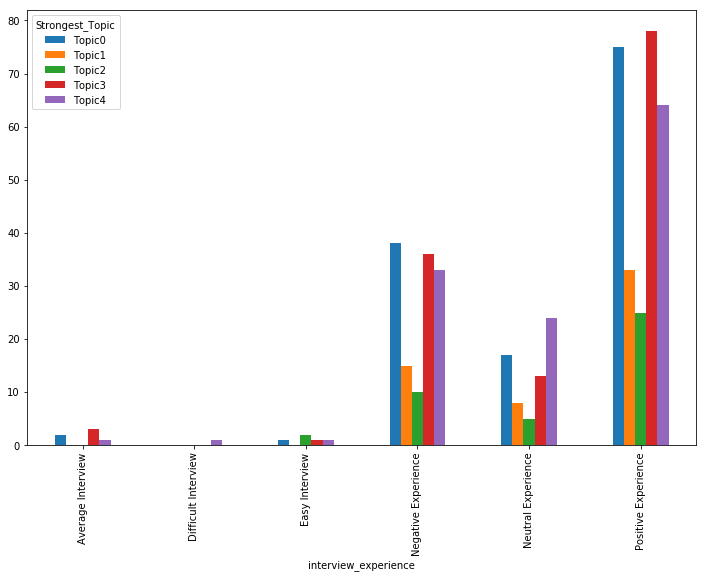

In [67]:
interviews_categorized.groupby(['interview_experience','Strongest_Topic']). \
    count()['company'].unstack().plot.bar(figsize=(12,8))
    
#Looks like interview experience is capturing `interview_difficulty` in some cases. 
#Likely need to address within the web scraping script